In [1]:
# %%capture
# !pip install datasets==2.0.0
# !pip install transformers==4.15.0
# !pip install librosa
# !pip install jiwer

In [2]:
# !pip install torchaudio==0.9.1

In [3]:
# import torchaudio
# torchaudio.__version__

In [4]:
# from huggingface_hub import notebook_login
# notebook_login()

In [1]:
from datasets import load_dataset
import os
import sys
import pickle
import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from joblib import Parallel, delayed
import math
import random
import shutil
import cv2
# import clip
import torch
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
import statistics

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [2]:
def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(100, 100)):

    w, h = size
    labels = ds['train'].features['category'].names
    labels = labels[:9]
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("./fonts/LiberationMono-Bold.ttf", 24)
    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['category'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, str(label), (255, 255, 255), font=font)

    return grid

def delete_ipynb_checkpoints():
    # delete all .ipynb_checkpoints dir
    for filename in Path(os.getcwd()).glob('**/*.ipynb_checkpoints'):
        try:
            shutil.rmtree(filename)
        except OSError as e:
            print(e)
        else: 
            print("The %s is deleted successfully" % (filename))  
delete_ipynb_checkpoints()

The /workspace/AIcup/orchid219_classification/.ipynb_checkpoints is deleted successfully


# 整理 Orchid219 Classification Datasets (IC)

In [3]:
df = pd.read_csv('./datasets/orchid219/label.csv', encoding="utf8")
df

,filename,category
0,me3uqlixjn.jpg,0
1,5c0vsrdtpq.jpg,0
2,swixut5b3l.jpg,0
3,m0eqa926lo.jpg,0
4,5jr6x2y9p8.jpg,0
...,...,...
2185,9a4ryif2xc.jpg,218
2186,nhs2oz6q7g.jpg,218
2187,atvix0fwnq.jpg,218
2188,wpd8temlgf.jpg,218


In [4]:
df["category"].value_counts()

0      10
150    10
139    10
140    10
141    10
       ..
76     10
77     10
78     10
79     10
218    10
Name: category, Length: 219, dtype: int64

In [8]:
# todo_file = [str(i) for i in list(Path(os.path.join('ic')).rglob('**/*-*-*.mp3'))]
# len(todo_file)

## 產生CSV資料集 all.csv,train.csv,valid.csv

In [9]:
# Let's say we want to split the data in 80:10:10 for train:valid:test dataset
train_size=0.9

X = df.drop(columns = ['category']).copy()
y = df['category']

# In the first step we will split the data in training and remaining dataset
X_train, X_valid, y_train, y_valid = train_test_split(X,y, train_size=train_size, random_state=109)


print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)

df_train = X_train
df_train['category'] = y_train

df_valid = X_valid
df_valid['category'] = y_valid

df_train.to_csv(os.path.join('datasets','orchid219', 'train.csv'), index=False)
df_valid.to_csv(os.path.join('datasets','orchid219', 'validation.csv'), index=False)

(1971, 1)
(1971,)
(219, 1)
(219,)


In [15]:
! ls /root/.cache/huggingface/datasets/downloads/extracted/884899cd1ab66e5156c8b858277589d61b4eba6931f350e3d0cc31d3ac0f939d/orchid219

02a91mzn84.jpg	70wzcgx3fm.jpg	e5yusoh287.jpg	le15pinmv8.jpg	sghqf82v0z.jpg
02nehv1tf6.jpg	713yghkidx.jpg	e6mbk9qrhz.jpg	lejf4bm0pn.jpg	sguq8n5mr4.jpg
02sx9ijfd6.jpg	71moswf85d.jpg	e7vqtr3fw4.jpg	lf4n7pykm0.jpg	shrd4c8pou.jpg
032p7z15ol.jpg	71qxlzfrd4.jpg	e81wtuhipc.jpg	lgwndzjsy0.jpg	si9z74bct1.jpg
03jezhu9i8.jpg	72auvi8oye.jpg	e8soz0ldnk.jpg	lhgy7afrkz.jpg	sicx6lo4eu.jpg
03ol9zqjn7.jpg	72isl14kn9.jpg	e8vxag7m2p.jpg	lhtjb3x8z7.jpg	sj7r4dwhbu.jpg
04d6xbohpg.jpg	72k0v5cjox.jpg	e9jhyfd1l3.jpg	lja6bvp21x.jpg	sjiv809m7g.jpg
04kxsd2rf9.jpg	735gqwclov.jpg	ebguj8d9of.jpg	ljqhw0t68d.jpg	sk3rb1in7f.jpg
05tdemvcqx.jpg	73dfup40bj.jpg	ebyk9ncgfu.jpg	lkqajngu4m.jpg	sk8hfvx20r.jpg
06uasyi3nt.jpg	73ye0lkw1g.jpg	ecakwboqv9.jpg	lm98b5ai6j.jpg	slitg053cu.jpg
07ufd3njrv.jpg	745f9kaumw.jpg	ecdlfj85aq.jpg	lmkbtd2os3.jpg	smhd3q9uj7.jpg
07uqc9hdnt.jpg	74gzbm9r3j.jpg	edqpj7lc9w.jpg	lmwtoh38a9.jpg	snfirgdj6h.jpg
084dzytmfe.jpg	74j8wsaepr.jpg	ef1hxjb78k.jpg	lnscbdo90j.jpg	so92rqmze5.jpg
09de32ybos.jpg	751qgzdves

## 打包好 orchid219.zip後，驗證一下

In [17]:
from datasets import load_dataset
dataset = load_dataset('./datasets/orchid219.py')
dataset.cleanup_cache_files()

No config specified, defaulting to: orchid219/orchid219
Reusing dataset orchid219 (/root/.cache/huggingface/datasets/orchid219/orchid219/0.0.2/71f0b7cc14767a4eecec1f3560d77a9d0f8265e963eba1b09fabbe834625b44e)


  0%|          | 0/2 [00:00<?, ?it/s]

{'train': 0, 'validation': 0}

In [18]:
dataset

DatasetDict({
    train: Dataset({
        features: ['filename', 'image', 'category'],
        num_rows: 1971
    })
    validation: Dataset({
        features: ['filename', 'image', 'category'],
        num_rows: 219
    })
})

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

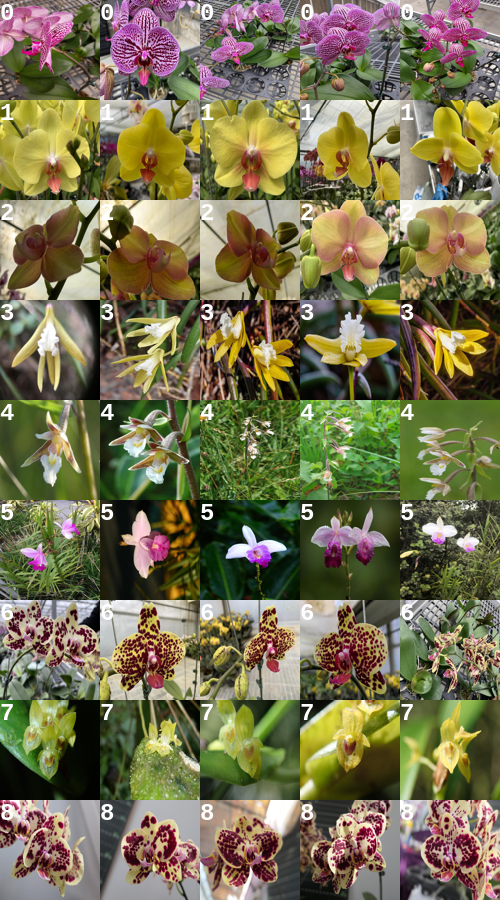

In [19]:
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image

show_examples(dataset, seed=random.randint(0, 1337), examples_per_class=5)

## 打包好 orchid219.zip後，驗證一下 google drive datasets

In [22]:
from datasets import load_dataset
dataset = load_dataset('./datasets/orchid219.py')
dataset.cleanup_cache_files()
dataset

No config specified, defaulting to: orchid219/orchid219
Reusing dataset orchid219 (/root/.cache/huggingface/datasets/orchid219/orchid219/1.0.0/aac086da2eeb0876c44cc76dd24d57f2eace0f6d090bfac7174db5450d91394a)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['filename', 'image', 'category'],
        num_rows: 1971
    })
    validation: Dataset({
        features: ['filename', 'image', 'category'],
        num_rows: 219
    })
})

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

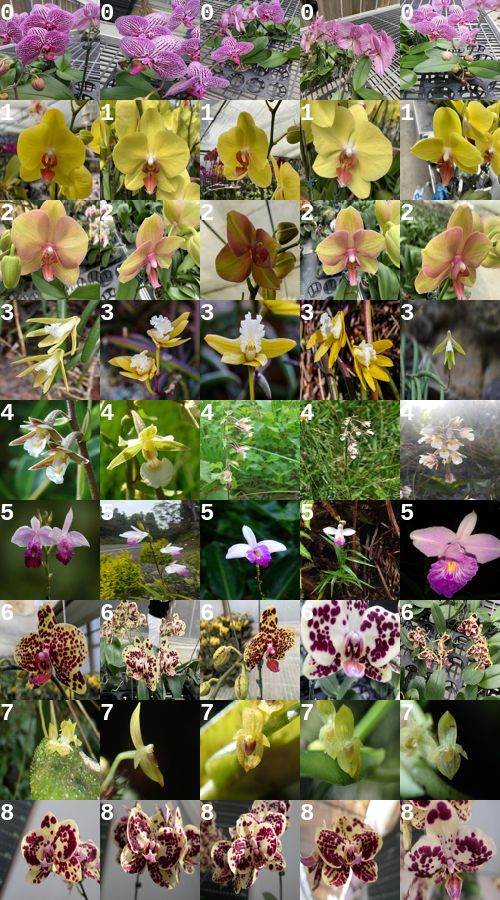

In [23]:
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image

show_examples(dataset, seed=random.randint(0, 1337), examples_per_class=5)

## 送到Huggingface Hub datasets

In [24]:
from huggingface_hub import notebook_login
notebook_login()

In [25]:
dataset.push_to_hub("gary109/orchid219")

Pushing split train to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

HTTPError: 502 Server Error: Bad Gateway for url: https://huggingface.co/api/datasets/gary109/orchid219/upload/main/data/train-00000-of-00001.parquet

## 打包好 orchid219.zip後，驗證一下 Hub上的 datasets

In [5]:
from datasets import load_dataset
dataset = load_dataset("gary109/orchid219", use_auth_token=True)

Downloading:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

Using custom data configuration gary109--orchid219-f4afad8d7a190c58


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/gary109--orchid219-f4afad8d7a190c58/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
dataset

DatasetDict({
    test: Dataset({
        features: ['filename', 'image', 'labels'],
        num_rows: 219
    })
    train: Dataset({
        features: ['filename', 'image', 'labels'],
        num_rows: 1752
    })
    validation: Dataset({
        features: ['filename', 'image', 'labels'],
        num_rows: 219
    })
})